# Test for bike trafic model

In [1]:
import sys
from pathlib import Path

# Trouve le dossier racine du projet (celui qui contient 'src')
project_root = Path().resolve().parents[0]  # si ton notebook est dans 'notebook/'
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd
# import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from bike import indicators as ind
from bike import utils as ut
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix

from utils_traffic import *


No pre-existing parameter file exists for this project. Will use default


## Fonction definition

In [ ]:
def simple_bi(graph, coef = 1):
    for u, v, d in graph.edges(data=True):
        if d['type_bike'] == 'bike_lane':
            d['length_bi']= d['length']*0.9*coef
        elif d['type_bike'] == 'bike_path':
            d['length_bi']= d['length']*0.5*coef
        else:
            d['length_bi']= d['length']*2*coef
    return graph


def estimate_traffic (graph):
    for u,v,d in graph.edges(data=True):
        if d['type_car']=='primary':
            d['traffic']= 500
        elif d['type_car']=='secondary':
            d['traffic']=250
        else :
            d['traffic']=100

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 251:
        return 1.3
    elif traffic < 100:
        return 1
    else :
        return 1.1
    

def simple_bi_2(graph):
    for u,v,d in graph.edges(data=True):
        perceived_l = 0
        perceived_l += pl_type_bike(d['type_bike'])
        perceived_l += pl_slope(d['slope'])
        perceived_l += pl_green(d['green_blue_coverage'])
        perceived_l += pl_traffic(d['traffic'])
        d['length_bi'] = perceived_l/4



def traffic_assigment(graph, origin, destination, demand, weight='length', print_path=False, flow_key='flow'):
    for u, v, d in graph.edges(data=True):
        if flow_key not in d:
            d[flow_key] = 0
    #shortest path calculation based on 'weight' attribute
    path = nx.shortest_path(graph, source=origin, target=destination, weight=weight)
    #increment traffic on each edge in the path
    for i in range(len(path)-1):
        u = path[i]
        v = path[i+1]
        graph[u][v][flow_key] += demand
        #try :
        #    graph[u][v]['flow'] += demand
        #except KeyError:
        #    graph[u][v][key]['flow'] += demand
    if print_path:
        return path
    
def reset_flows(graph, flow_key='flow'):
    for u, v, d in graph.edges(data=True):
        d[flow_key] = 0

def plot_flow(G, title, pos=None, flow_key='flow', ax=None, fig=None):
    if pos is None:
        pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    # Récupérer les valeurs de flow pour normaliser les couleurs
    flows = [data.get(flow_key, 0) for u, v, data in G.edges(data=True)]
    max_flow = max(flows) if flows else 1

    # Créer une colormap basée sur le flow

    norm = plt.Normalize(vmin=0, vmax=max_flow)
    cmap = cm.Reds

    edge_colors_flow = [cmap(norm(data.get(flow_key, 0))) for u, v, data in G.edges(data=True)]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
        
    nx.draw(G, pos=pos, node_size=10, node_color='lightblue', 
        edge_color=edge_colors_flow, width=1.5, arrows=False, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d[flow_key]:.2f}" for u, v, d in G.edges(data=True)}, font_color='black', ax=ax)
    ax.set_title(title)

    plt.show()

def plot_graph(G, label='length_bi'):
    pos = {n: (d["x"], d["y"]) for n, d in G.nodes(data=True)}
    color_map = {'bike_path': '#4E9F50FF', 'bike_lane': '#EF8A0CFF'}
    edge_colors = []

    for _, _, edge in G.edges(data=True):
        # Détermination de la couleur en fonction de 'type_bike'
        bike_type = edge.get('type_bike')
        edge_colors.append(color_map.get(bike_type, "black"))

    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(G, ax=ax, pos=pos, with_labels=True, node_size=300, font_size=8, edge_color=edge_colors, width=3, edgecolors="black", node_color="white")
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d[label] for u, v, d in G.edges(data=True)}, font_color='black')
    legend_elements = [
    Line2D([0], [0], color='black', lw=1.5, label='No bike infrastructure'),
    Line2D([0], [0], color=color_map['bike_lane'], lw=1.5, label='bike_lane'),
    Line2D([0], [0], color=color_map['bike_path'], lw=1.5, label='bike_path'),
]
    ax.legend(handles=legend_elements, loc='lower right')
    plt.axis("equal")
    plt.show()

def reset_index(G):
    return nx.convert_node_labels_to_integers(G, label_attribute='old_id')

def code_to_int(code):
    letter = code[0]
    number = int(code[1])
    return (ord(letter) - ord('A')) * 2 + number

##### eaquilibrae pre processing

def convert_to_eaquilibrae_df(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    return edges_df

def convert_to_eaquilibrae_od_matrix(od_matrix):
    od_long = od_matrix.stack().reset_index()
    od_long.columns = ["origin", "destination", "demand"]
    return od_long

def convert_from_eaquilibrae_df_to_graph(results_stochastic, G):
    #flows = results_stochastic['flow']
    #times = results_stochastic['time']
    network_with_flows = results_stochastic['network']
    #route_choices = results_stochastic['route_choice_results']
    nodes_data = [{'id': node, 'x':data['x'], 'y':data['y']} for node, data in G.nodes(data=True)]
    #nodes_gdf = gpd.GeoDataFrame(nodes_data)
    G_2 = nx.from_pandas_edgelist(
    network_with_flows,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2

#####models

def model_all_or_nothing(G, od_matrix, weigth, flow_key='flow'):
    reset_flows(G, flow_key=flow_key)
    for origin in od_matrix.index:
        for destination in od_matrix.columns:
            if od_matrix.loc[int(origin), int(destination)] > 0:
                demand = od_matrix.loc[origin, destination]
                origin = str(origin)
                destination = str(destination)
                traffic_assigment(G, origin=origin, destination=destination, demand=demand, weight=weigth, flow_key=flow_key)


def model_eaquilibrae_stochastic(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df = convert_to_eaquilibrae_df(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph(results_stochastic, G)
    return G_2



In [3]:
def generate_od_matrix(G, weight_0=0.4):    
    zones = G.nodes()
    valeurs = np.arange(0, 11)
    poids = [weight_0] + [(1 - weight_0)/10] * 10

    matrice = np.random.choice(valeurs, size=(len(zones), len(zones)), p=poids)
    np.fill_diagonal(matrice, 0)
    # Créer un DataFrame pour plus de lisibilité
    od_matrix = pd.DataFrame(matrice, index=zones, columns=zones)

    return od_matrix

## Import and pre proccessing

In [3]:
G = nx.read_graphml("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/small_grid_graph.graphml")
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

In [4]:
print(ind.compute_all_indicators(G))
estimate_traffic(G)
simple_bi(G, coef=1)

{'Size': 24.0, 'Granularity': 1.0, 'Coverage': 0.4583333333333333, 'Degree Centrality': 2.0, 'Betweenness Centrality': 3.1533333333333333, 'Number of Components': 1, 'Component Sizes': [0.458], 'Connectivity': 0.5530303030303029, 'Density 1': 0.041666666666666664, 'Global Efficiency': 0.5151515151515154, 'Local Efficiency': 0.0}


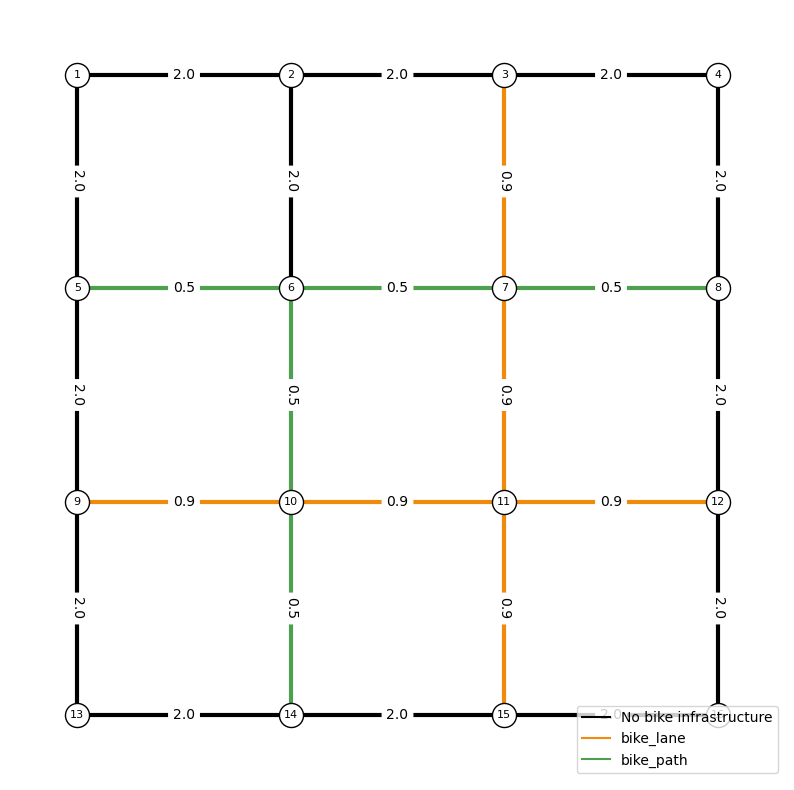

In [5]:
plot_graph(G)

In [26]:
modal_share = {'bike': 0.25, 'car': 0.75}
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
od_matrix.loc[1,16] = 100
od_matrix.loc[2,14]=100
od_bike = od_matrix.copy()
od_bike = od_bike*modal_share['bike']
od_car = od_matrix.copy()
od_car = od_car*modal_share['car']

In [27]:
reset_flows(G)

## Models

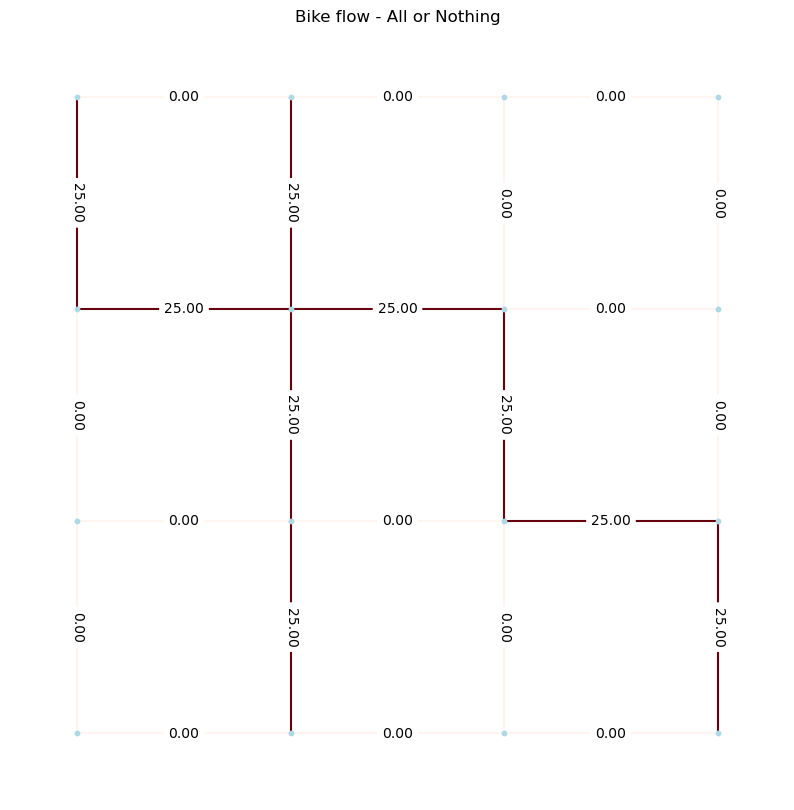

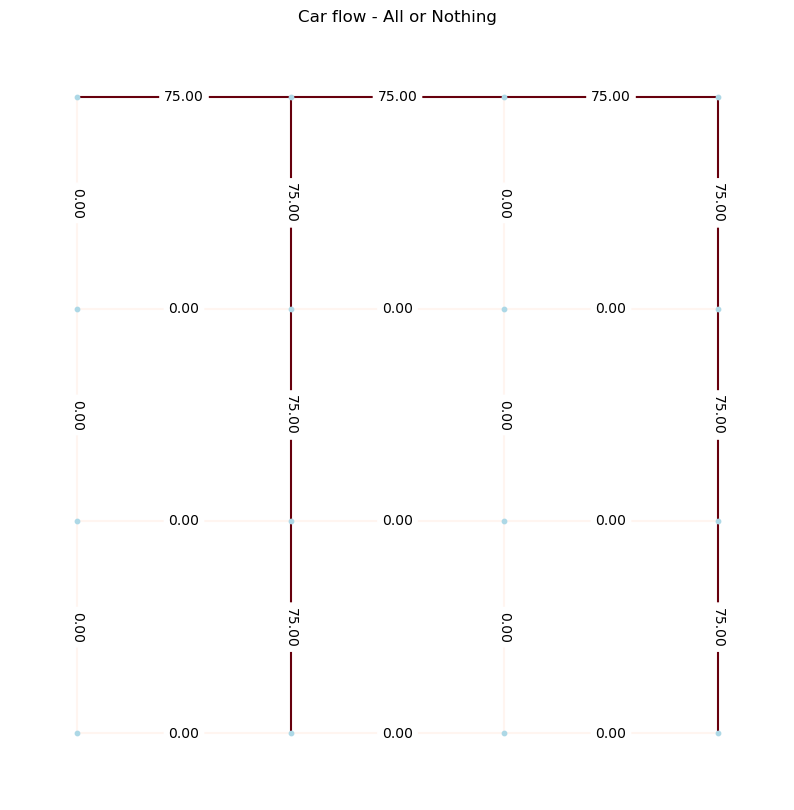

In [28]:
model_all_or_nothing(G, od_bike, weigth='length_bi', flow_key='flow_bike')
plot_flow(G, title="Bike flow - All or Nothing", pos=pos, flow_key='flow_bike')
model_all_or_nothing(G, od_car, weigth='length', flow_key='flow_car')
plot_flow(G, title="Car flow - All or Nothing", pos=pos, flow_key='flow_car')

Starting stochastic assignment with bfsle algorithm...
Assignment completed successfully in 0.00 seconds.
Assignment Results:
Algorithm: bfsle
Max Routes: 3
Total Travel Time: 15.00

Total Travel Cost: 245.00



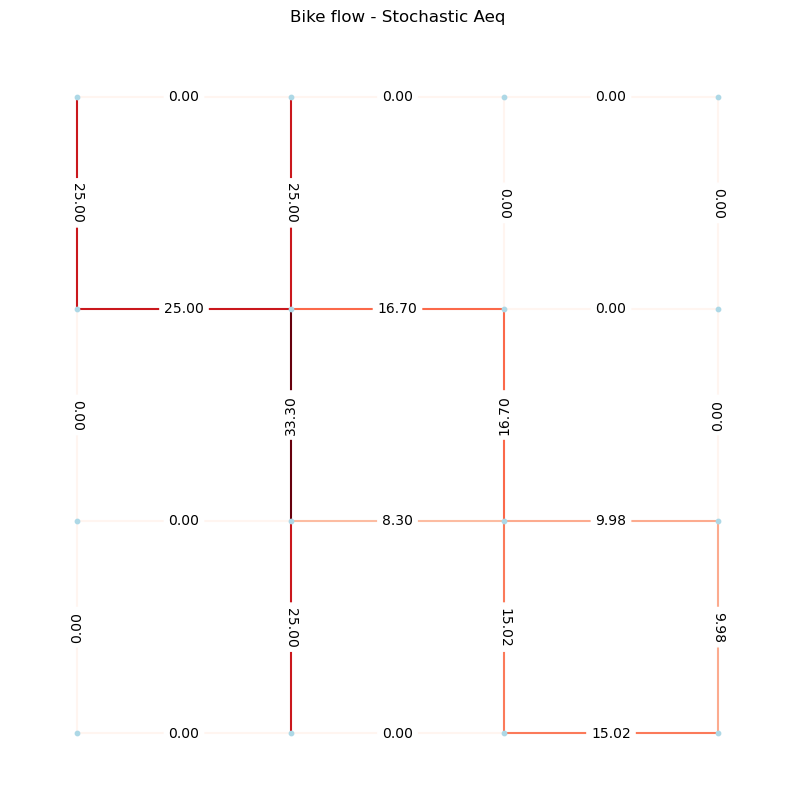

Starting stochastic assignment with bfsle algorithm...
Assignment completed successfully in 0.00 seconds.
Assignment Results:
Algorithm: bfsle
Max Routes: 3
Total Travel Time: 26.75

Total Travel Cost: 675.00



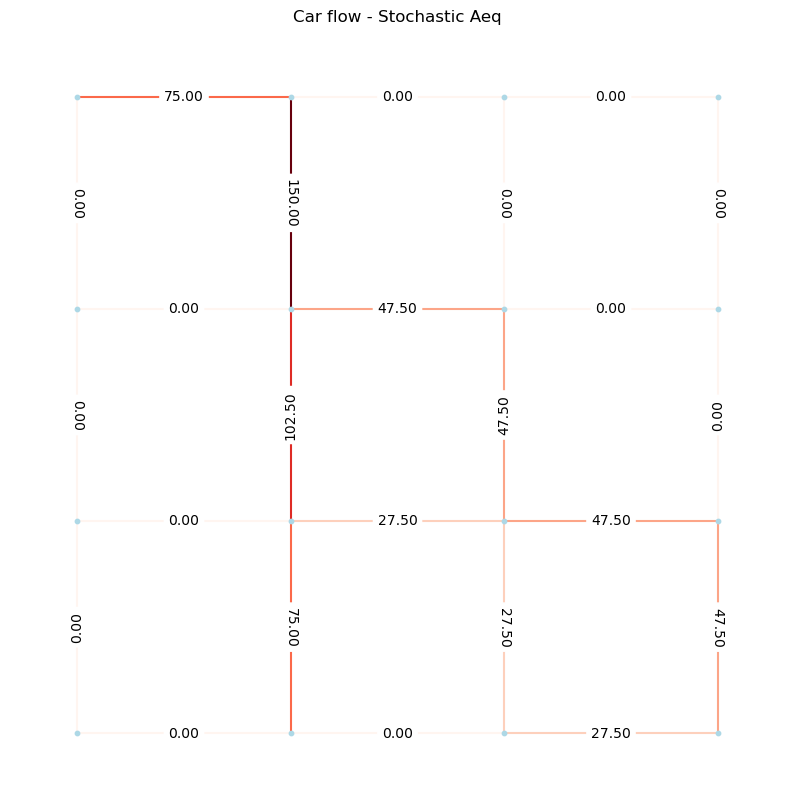

In [29]:
G_sto_bike = model_eaquilibrae_stochastic(G, od_bike, time_field='travel_time_bike', cost_field='length_bi', algorithm='bfsle', max_routes=3)
plot_flow(G_sto_bike, title="Bike flow - Stochastic Aeq", pos=pos, flow_key='flow')
G_sto_cars = model_eaquilibrae_stochastic(G, od_car, time_field='travel_time_cars', cost_field='length', algorithm='bfsle', max_routes=3)
plot_flow(G_sto_cars, title="Car flow - Stochastic Aeq", pos=pos, flow_key='flow')

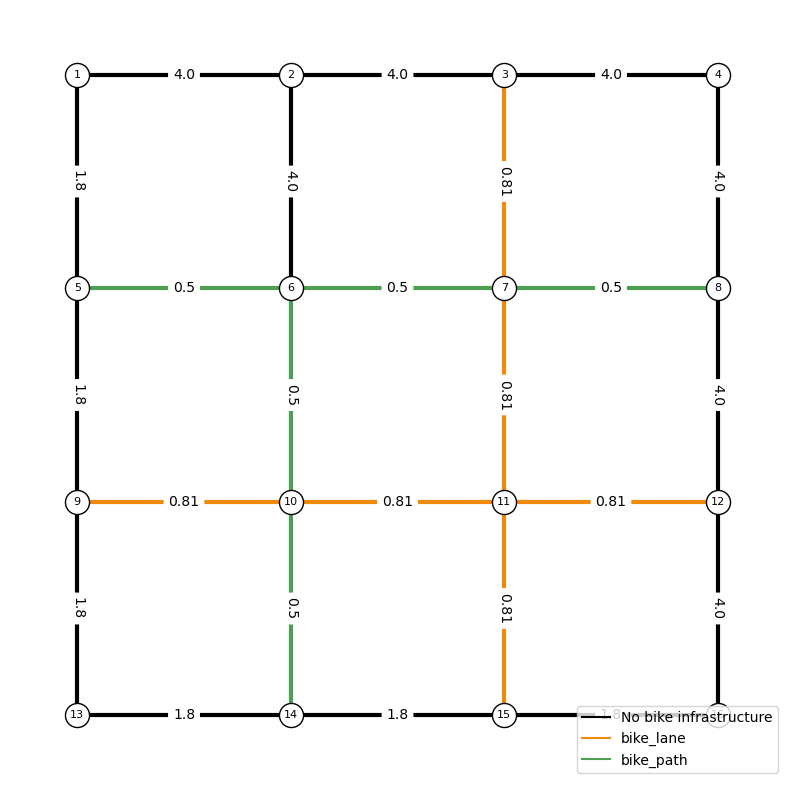

In [30]:
weight_bl = 0.9
weight_bp = 0.5
weight_no = 2
weight_no_traffic = 0.9
weight_medium_traffic = 1.1
weight_high_traffic = 2
tresh_no_traffic = 10
tresh_medium_traffic = 20

def simple_bi_3(graph):
    for u,v,d in graph.edges(data=True):
        perceived_l = d['length']
        if d['type_bike'] == 'bike_path':
            perceived_l *= weight_bp
        elif d['type_bike'] == 'bike_lane':
            if d['flow_car'] < tresh_no_traffic:
                perceived_l *= weight_bl*weight_no_traffic
            elif d['flow_car'] < tresh_medium_traffic:
                perceived_l *= weight_bl*weight_medium_traffic
            else :
                perceived_l *= weight_bl*weight_high_traffic
        else :
            if d['flow_car'] < tresh_no_traffic:
                perceived_l *= weight_no*weight_no_traffic
            elif d['flow_car'] < tresh_medium_traffic:
                perceived_l *= weight_no*weight_medium_traffic
            else :
                perceived_l *= weight_no*weight_high_traffic
        d['length_bi'] = perceived_l

G_bi_3 = G.copy()
simple_bi_3(G_bi_3)
reset_flows(G_bi_3)
plot_graph(G_bi_3, label='length_bi')

Starting stochastic assignment with bfsle algorithm...
Assignment completed successfully in 0.00 seconds.
Assignment Results:
Algorithm: bfsle
Max Routes: 3
Total Travel Time: 15.00

Total Travel Cost: 284.74



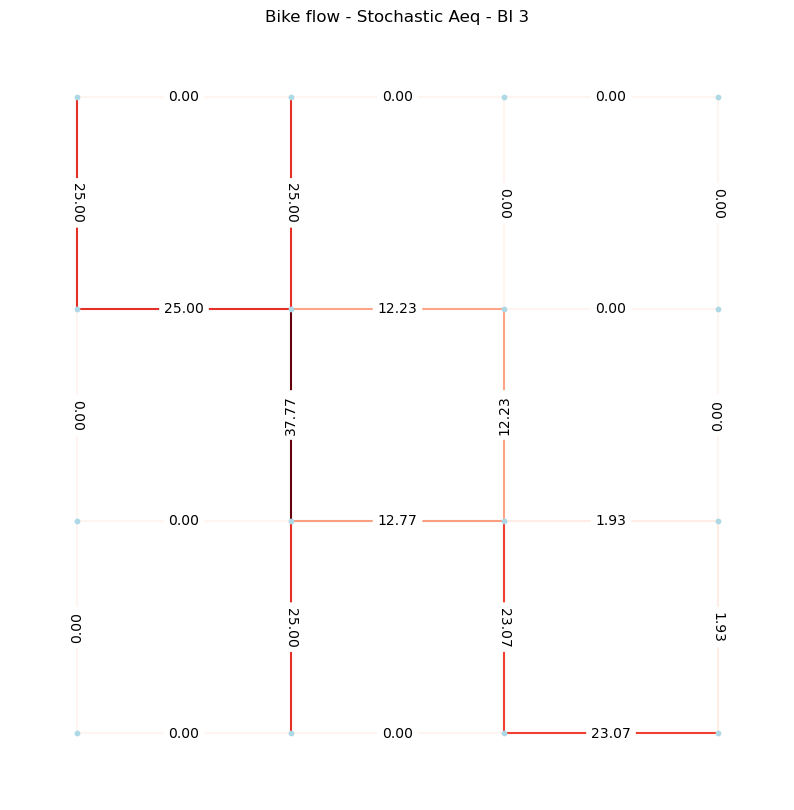

In [31]:
G_sto_bike_3 = model_eaquilibrae_stochastic(G_bi_3, od_bike, time_field='travel_time_bike', cost_field='length_bi', algorithm='bfsle', max_routes=3)
plot_flow(G_sto_bike_3, title="Bike flow - Stochastic Aeq - BI 3", pos=pos, flow_key='flow')

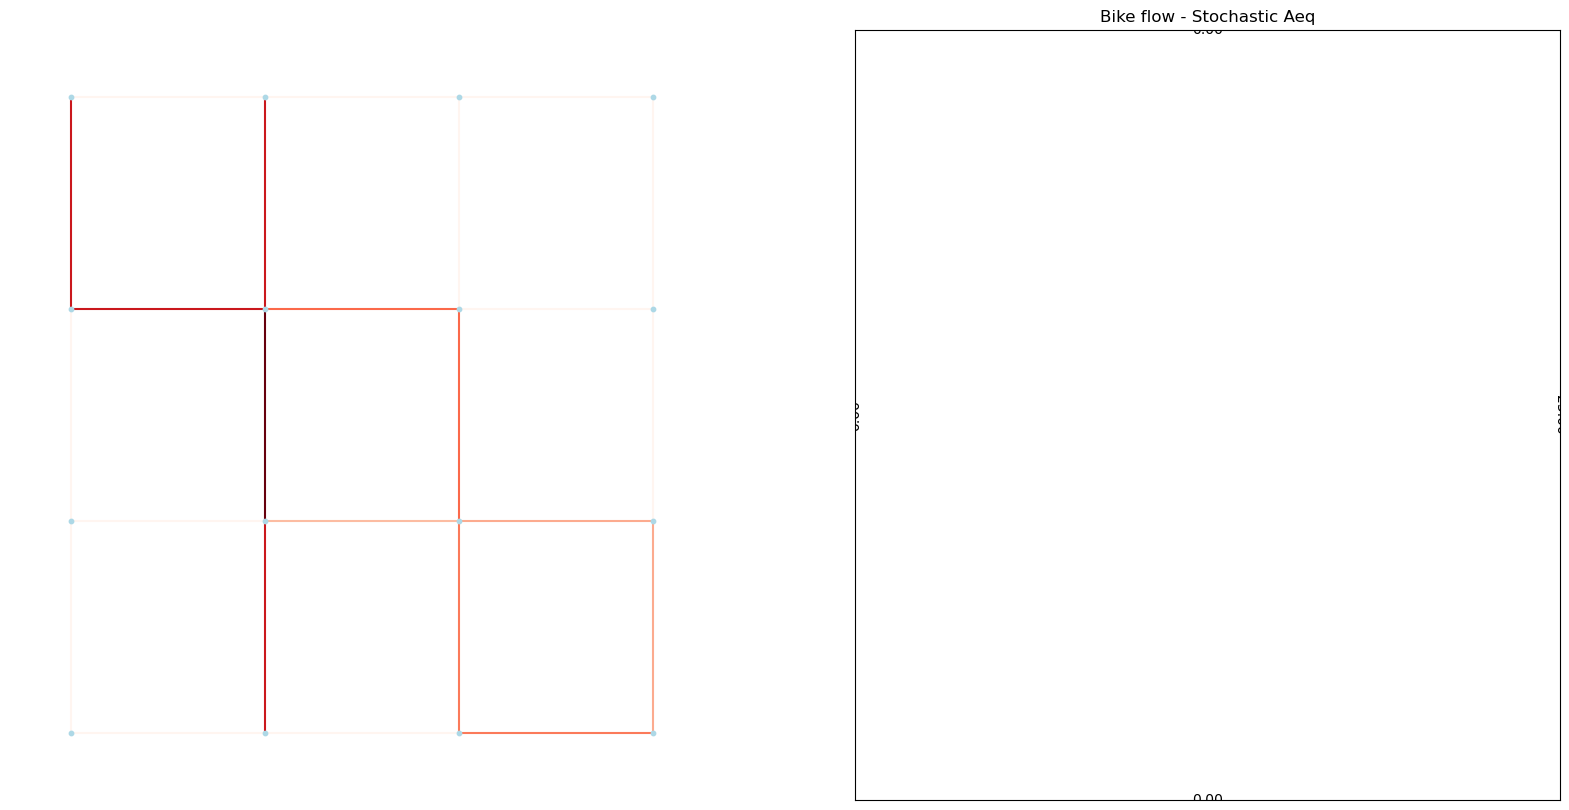

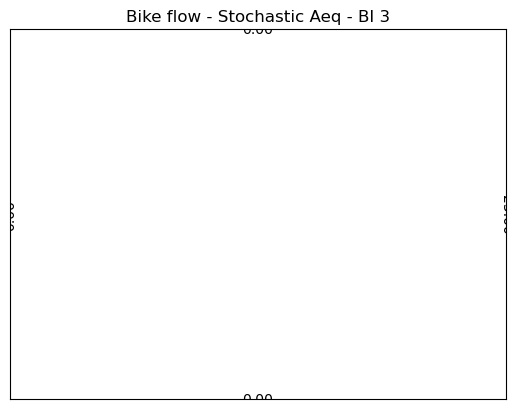

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_flow(G_sto_bike, title="Bike flow - Stochastic Aeq", pos=pos, flow_key='flow', ax=axes[0])
plot_flow(G_sto_bike_3, title="Bike flow - Stochastic Aeq - BI 3", pos=pos, flow_key='flow', ax=axes[1])